# SOMOSPIE study cases

This Jupyter Notebook presents a example of using SOMOSPIE for modeling and visualizing soil moisture in a region of interest (ROI). The region of interest can be Gatlinburg, Oklahoma, CONUS. We will downscale soil moisture from 27 km to different fine-grained resolutions. We will explore 4 different models with different configurations so the user has a better understanding of the different models. In the end, the user will be able to visualize the original data and the finer-grained predictions generated by each model.   
* Regions (Resolution): Gatlinburg (1 m), Oklahoma (90 m, 250 m, and 1 km), and CONUS (1 km)
* Models:  KNN; Random Forest; Surrogate Based Modeling; HYPPO

This Jupyter Notebook is a result of a collaboration between computer scientists of the Global Computing Laboratory at the Universtiy of Tennessee, Knoxville and soil scientists at the University of Delware (funded by NSF awards #1724843 and #1854312).

# Environment Setup

Run the following code box to set the working directories and packages necessary for this workflow 

In [ ]:
import os 
import time
import gdown 
from pathlib import Path
HOME=Path.home()
SOMOSPIE=str(HOME)+"/Src_SOMOSPIE/SOMOSPIE"
TESTS=str(HOME)+"/Src_SOMOSPIE/tests"
os.chdir (SOMOSPIE)
DATA=str(SOMOSPIE)+"/data"
CODE=str(SOMOSPIE)+"/code"
print ("Our working directory is:")
%pwd

# Collecting coarse soil moisture data 

In the code cell below, specify the resolution at which you will predict the soil moisture data from the region of interest (Oklahoma). 

In [1]:
gatlinburg_1m = "https://drive.google.com/drive/folders/16-tkdu5V5m9zd-swDcOLmmcQXtIOIqZJ"
oklahoma_1km = "https://drive.google.com/drive/folders/1g5VQaOHAsoTkfMo7EWPNWBinrIguMG5i"
oklahoma_250m = "https://drive.google.com/drive/folders/1gXFPbsQgaxiw9sfryOt0fZLOdzRn0kg_"
oklahoma_90m = "https://drive.google.com/drive/folders/1TKBrlS-amkmzZyr3MlW3_cVwX_88z5Gj"
conus_1km = "https://drive.google.com/drive/folders/112_Uo-h9Bf5k_y1h6htBTYZMPjpcFcYz"


Select a dataset to predict: `"gatlinburg_1m"` or `"oklahoma_90m"`. By default this jupyter notebook runs with `"oklahoma_1km"`.

In [1]:
#Select the region
region = "oklahoma_1km"

In [7]:
from pathlib import Path
Path(DATA+"/"+region+"/").mkdir(parents=True, exist_ok=True)

if region == "gatlinburg_1m":
    url = gatlinburg_1m
elif region == "oklahoma_1km":
    url = oklahoma_1km 
elif region == "oklahoma_250m":
    url = "oklahoma_250m"
elif region == "oklahoma_90m":
    url = "oklahoma_90m"
    

In [ ]:
#Read data from Google Drive
%cd $DATA
gdown.download_folder(url)

# Modeling fine-grained soil moisture data 

We explore 4 Machine Learning methods built in SOMOSPIE:
 * KKNN, Kernel-wighted K-Nearest Neighbors (Python)  
    Models locally with a weighted mean of the k nearest training points.
 * RF, Random Forests (Python)    
    Models with a weighted sum of global inference trees.  
 * HYPPO, HYbrid Piecewise POlynomial method (Python)  
    Models with local best-fit polynomials generated by the k nearest training points.
 * SBM, Surrogate-Based Modeling (Python)  
    Models with a global best-fit polynomial generated by random samples of training points.

In the next cells, we will execute each model: knn, rf, hyppo, and sbm, specifying their parameters.We will compare accuracy and time performance for each model.  

In [ ]:
#Importing modules from modeling 
%pwd
%cd $SOMOSPIE

import sys
sys.path.insert(0, SOMOSPIE+"/code/modeling/")

## **KNN: k-Kearest Neighbors**

In [ ]:
model="knn"
from knn import *

start = time.time()
#Input arguments to execute the k-Nearest Neighbors Regression 
parser = get_parser()
args = parser.parse_args(["-t", DATA+"/"+region+"/train.csv", 
                          "-e", DATA+"/"+region+"/eval.csv", 
                          "-o", DATA+"/"+region+"/predictions_"+model+".csv" ])
training_data, maxK, seed, evaluation_data, output_data = from_args_to_vars(args)

x_train, y_train, x_test, y_test, ss = split_and_preprocess_trainingdata (training_data)
knn = train_knn(x_train, y_train, maxK, seed, ss)
validate_knn(knn, x_test, y_test)
print("Constructing model done")
x_predict = preprocess_evaluationdata (evaluation_data, ss)
predict_knn(x_predict, evaluation_data, output_data, knn)
print("Evaluating model done")
end = time.time()
print("It took " + str(end - start) + " seconds to perform model all the points.")

## **RF: Random Forest** 

In [ ]:
model="rf"
from rf import *

start = time.time()
parser = get_parser()
args = parser.parse_args(["-t", DATA+"/"+region+"/train.csv", 
                          "-e", DATA+"/"+region+"/eval.csv", 
                          "-o", DATA+"/"+region+"/predictions_"+model+".csv"])
training_data, evaluation_data, output_data, maxtree, seed = from_args_to_vars(args)

x_train, y_train, x_test, y_test, ss = split_and_preprocess_trainingdata (training_data)
rf = train_rf(x_train, y_train, maxtree, seed)
validate_rf(rf, x_test, y_test)
print("Constructing model done")
x_predict = preprocess_evaluationdata (evaluation_data, ss)
predict_rf(x_predict, evaluation_data, output_data, rf)
print("Evaluating model done")
end = time.time()
print("It took " + str(end - start) + " seconds to perform model all the points.")

## **HYPPO: a surrogate-based multi-level parallelism tool for HYPerParameter Optimization** 

This test is using the `hyppo.py` which is a A stripped-down version of hyppo7.py.

In [ ]:
model="hyppo_default"

from hyppo import * 
import time 

start = time.time()
parser = get_parser()
args = parser.parse_args(["-t", DATA+"/"+region+"/train.csv", 
                          "-e", DATA+"/"+region+"/eval.csv", 
                          "-o", DATA+"/"+region+"/predictions_"+model+".csv",
                          "-k", "10", #The number of nearest neighbors
                          "-D", "3", # Maximum polynomial degree
                          "-p","0", #Run with pyspark 0:No 1:Yes
                          "-L","0" #Run with Lasso 0:No 1:Yes
                         ])

# Read in the training data and evaluation data and save to numpy dataframes
original_values = np.loadtxt(args.train, delimiter=args.delimiter, skiprows=args.headerRows)
log(f"\n{len(original_values)} lines of original data have been loaded from {args.train}.\n", file=args.logFile)
values_to_model = np.loadtxt(args.eval, delimiter=args.delimiter, skiprows=args.headerRows)
log(f"{len(values_to_model)} lines of evaluation data have been loaded from {args.eval}.\n", file=args.logFile)

output = main(original_values, values_to_model, args)

np.savetxt(args.out, output, delimiter=",", fmt='%.15f', header="x,y,sm")
end = time.time()
print("It took " + str(end - start) + " seconds to perform model all the points.")
print("Constructing and evaluating the model done")

## **SBM: Surrogate-Based Modeling** 

In [ ]:
model="sbm"

from hyppo import * 
import time 

start = time.time()
parser = get_parser()
args = parser.parse_args(["-m", "SBM",
                          "-t", DATA+"/"+region+"/train.csv", 
                          "-e", DATA+"/"+region+"/eval.csv", 
                          "-o", DATA+"/"+region+"/predictions_"+model+".csv",
                          "-k", "10", #The number of folds in cross validation
                          "-D", "3", # Maximum polynomial degree
                          "-p","0", #Run with pyspark 0:No 1:Yes
                          "-L","0" #Run with Lasso 0:No 1:Yes
                         ])

# Read in the training data and evaluation data and save to numpy dataframes
original_values = np.loadtxt(args.train, delimiter=args.delimiter, skiprows=args.headerRows)
log(f"\n{len(original_values)} lines of original data have been loaded from {args.train}.\n", file=args.logFile)
values_to_model = np.loadtxt(args.eval, delimiter=args.delimiter, skiprows=args.headerRows)
log(f"{len(values_to_model)} lines of evaluation data have been loaded from {args.eval}.\n", file=args.logFile)

output = main(original_values, values_to_model, args)

np.savetxt(args.out, output, delimiter=",", fmt='%.15f', header="x,y,sm")
end = time.time()
print("It took " + str(end - start) + " seconds to perform model all the points.")
print("Constructing and evaluating the model done")

# Visualizing fine-grained soil moisture data 

In [10]:
sys.path.insert(0, "code/")
from analysis.visualization import *

In [11]:
sm_min=0.175
sm_max=0.35

### 1) Plotting soil moisture values for different models

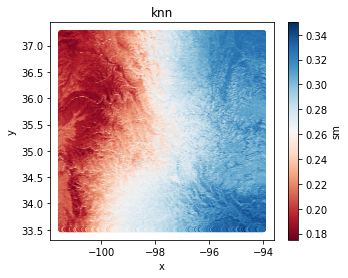

In [13]:
model="knn"
predictions=DATA+"/"+region+"/predictions_"+model
visualization (predictions+".csv", sm_min, sm_max, model, DATA+"/"+region+"/sm_"+model+".png")

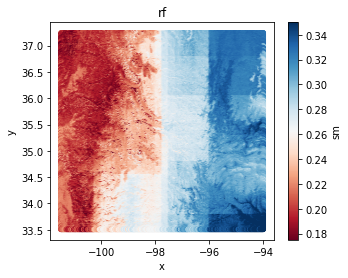

In [14]:
model="rf"
predictions=DATA+"/"+region+"/predictions_"+model
visualization (predictions+".csv", sm_min, sm_max, model, DATA+"/"+region+"/sm_"+model+".png")

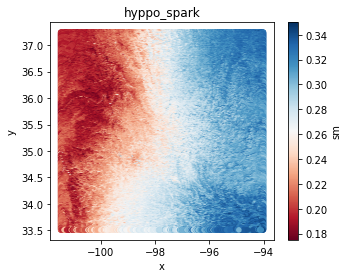

In [137]:
model="hyppo_spark"
predictions="../data/"+region+"/predictions_"+model
visualization (predictions+".csv", sm_min, sm_max, model, "../data/"+region+"/sm_"+model+".png")

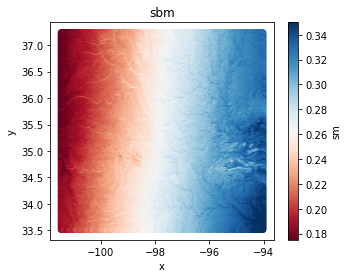

In [125]:
model="sbm"
predictions="../data/"+region+"/predictions_"+model
visualization (predictions+".csv", sm_min, sm_max, model, DATA+"/"+region+"/sm_"+model+".png")

### 2) Comparing soil moisture values for different models

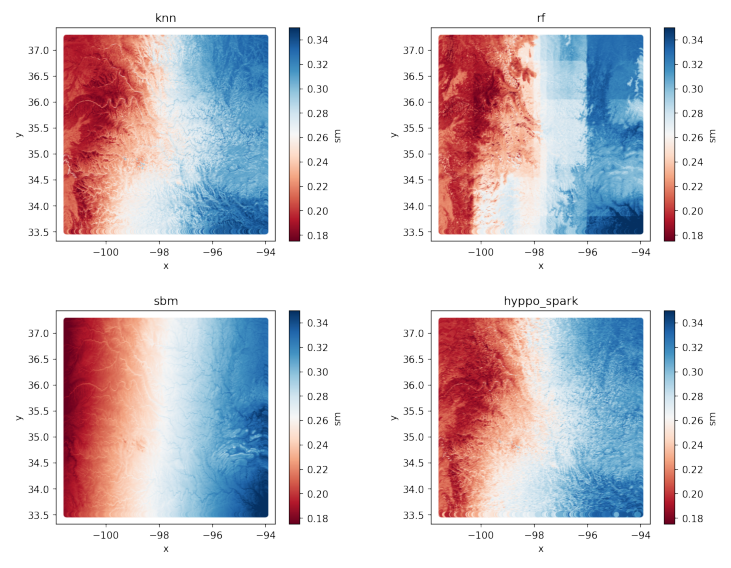

In [12]:
import matplotlib.image as mpimg

img1 = mpimg.imread("../data/"+region+"/sm_knn.png")
img2 = mpimg.imread("../data/"+region+"/sm_rf.png")
img3 = mpimg.imread("../data/"+region+"/sm_sbm.png")
img4 = mpimg.imread("../data/"+region+"/sm_hyppo_spark.png")

fig = plt.figure(figsize=(11, 8))
a=fig.add_subplot(2,2,1)
imgplot = plt.imshow(img1)
a.set_axis_off()
a=fig.add_subplot(2,2,2)
imgplot = plt.imshow(img2)
a.set_axis_off()
a=fig.add_subplot(2,2,3)
imgplot = plt.imshow(img3)
a.set_axis_off()
a=fig.add_subplot(2,2,4)
imgplot = plt.imshow(img4)
a.set_axis_off()
plt.tight_layout()
